# PPG from proximity sensor

In [26]:
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.fft as fft
import pandas as pd

In [4]:
path_to_data = os.path.join("..", "data", "recording-23-22-19-03-2023.txt")
data = pd.read_csv(path_to_data)

In [7]:
data

,TimestampSw,TimestampHw,Raw,Filtered
0,1679264536483,64164337.0,19097.0,-107.0
1,1679264536509,64184356.0,19097.0,-99.0
2,1679264536533,64204376.0,19104.0,-90.0
3,1679264536543,64224395.0,19104.0,-81.0
4,1679264536563,64244415.0,19101.0,-73.0
...,...,...,...,...
3385,1679264604261,131930450.0,19045.0,-59.0
3386,1679264604275,131950469.0,19045.0,-67.0
3387,1679264604290,131970489.0,19055.0,-71.0
3388,1679264604306,131990509.0,19055.0,-70.0


## Visualize data

Text(0.5, 1.0, 'Raw PPG signal')

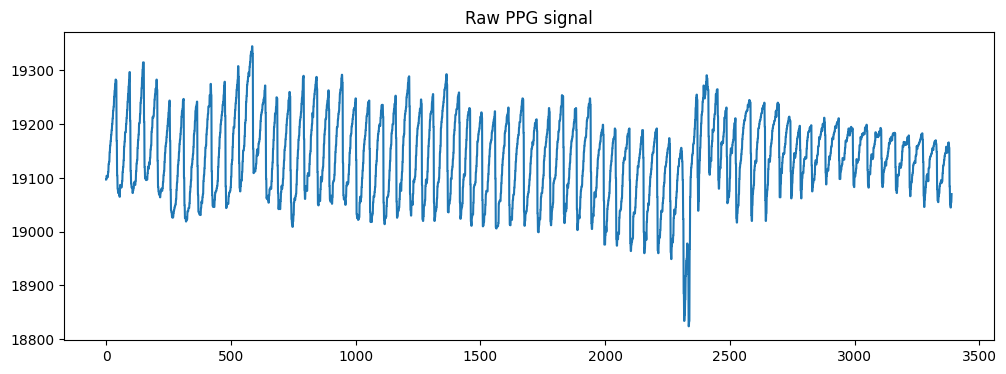

In [11]:
data["Raw"].plot(figsize=(12, 4))
plt.title("Raw PPG signal")

Text(0.5, 1.0, 'Filtered PPG signal')

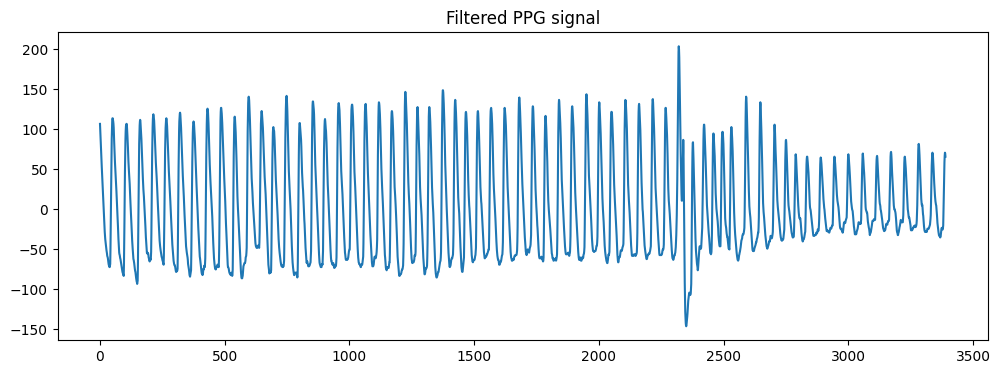

In [13]:
(-data["Filtered"]).plot(figsize=(12, 4))
plt.title("Filtered PPG signal")

In [16]:
# Calculate sampling frequency
fs = 1e6 / data["TimestampHw"].diff().mean()
print(f"Sampling frequency is {fs}")

Sampling frequency is 49.951219811293456


## Calculate and plot FFT, in chunks

In [46]:
def get_amp_spectrum(fs, x, n_fft=None, log=True):
    """Calculate the amplitude spectrum of the signal
    Args:
        fs (float): The sampling frequency
        x (np.ndarray): The input signal
        n_fft (int, optional): Number of points to calculate FFT.
        Defaults to None.
        log (bool, optional): Return the log of the spectrum. Defaults to True.
    Returns:
        f, x_spec: The frequencies for which the spectrum is calculated
        and the samples of the amplitude spectrum.
    """
    n = x.size
    if n_fft is None:
        n_fft = np.int(2**np.ceil(np.log2(n)))
    x_spec = fft.fft(x, n_fft)
    x_spec = np.abs(x_spec)
    x_spec = x_spec / n
    n_keep = int(n_fft/2) + 1
    x_spec = x_spec[0:n_keep]
    x_spec[1: -1] = 2 * x_spec[1: -1]
    f = np.linspace(0, fs/2, n_keep)
    if log:
        eps = 1e-10
        x_spec[x_spec < eps] = eps
        x_spec = 20 * np.log10(x_spec)
    return f, x_spec

Parameters for chunking the data and FFT calculations

In [49]:
t_win = 2
n_win = int(round(fs * t_win))
# n_fft = int(2**(np.ceil(np.log2(n_win))))
n_fft = 256

In [50]:
ppg_filtered = data["Filtered"].to_numpy()
windows = [ppg_filtered[i_win: i_win + n_win] for i_win in range(0, len(ppg_filtered), n_win)]

In [51]:
windows_fft = []
windows_freqs = []
for win in windows:
    win_freqs, win_fft = get_amp_spectrum(fs, win, n_fft=n_fft, log=False)
    windows_fft.append(win_fft)
    windows_freqs.append(win_freqs)

Visualize spectrum

Text(0.5, 1.0, 'Amplitude spectrum of PPG window')

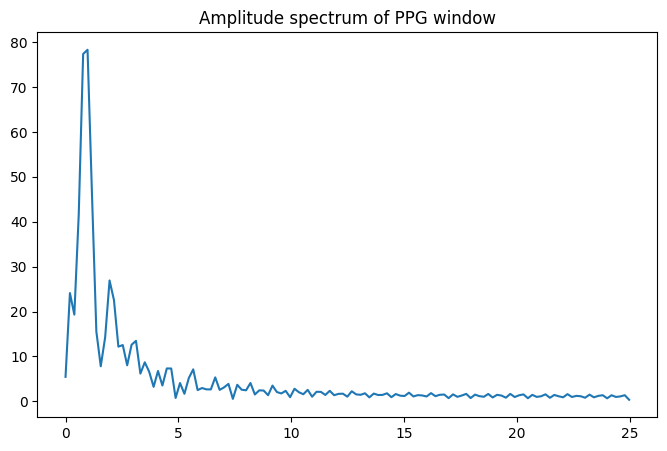

In [55]:
plt.figure(figsize=(8, 5))
plt.plot(windows_freqs[0], windows_fft[0])
plt.title("Amplitude spectrum of PPG window")

## Calculate BPM

Find frequency of max peak in spectrum to calculate the BPM

Text(0.5, 1.0, 'BPM value')

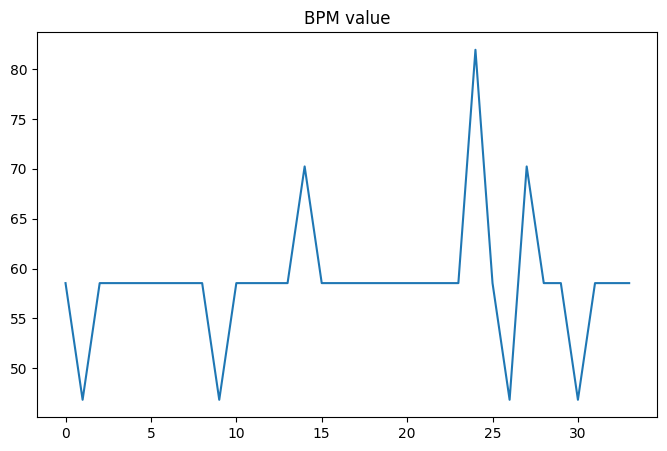

In [56]:
bpms = []
for win_freq, win_fft in zip(windows_freqs, windows_fft):
    bpm = 60 * win_freq[np.argmax(win_fft)]
    # limit bpm in some normal ranges
    bpm = 35 if bpm < 35 else 135 if bpm > 135 else bpm
    bpms.append(bpm)
bpms = np.array(bpms)
plt.figure(figsize=(8, 5))
plt.plot(bpms)
plt.title("BPM value")